In [ ]:
import sys
sys.path
sys.path.append('/volatile/aurelien_stumpf_mascles/project/code/')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import matplotlib.animation as animation
import tembedding
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS
import math
from joblib import Memory,Parallel,delayed,parallel_backend
import time
from multiprocessing import Lock, Process, Queue
import multiprocessing
import queue 
import os
import networkx as nx
from scipy.spatial.transform import Rotation as R

In [45]:
import importlib
importlib.reload(package.torch_classifier)
importlib.reload(cebra2.distribution)
importlib.reload(cebra2.dataset)

<module 'cebra_v2.dataset' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/dataset.py'>

## Utilitaires

In [2]:
def single_session_solver(data_loader, **kwargs):
    """Train a single session CEBRA model."""
    norm = True
    if kwargs['distance'] == 'euclidean':
        norm = False
    model = kwargs["model"]

    if kwargs['distance'] == 'euclidean':
        criterion = cebra2.criterion.EuclideanInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])
    elif kwargs['distance'] == 'cosine':        
        criterion = cebra2.criterion.CosineInfoNCE(temperature=kwargs['temperature'],beta = kwargs['beta'])

    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['learning_rate'])

    return cebra2.solver.SingleSessionSolver(model=model,
                                            criterion=criterion,
                                            optimizer=optimizer)

@torch.no_grad()
def get_emissions(model, dataset):
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
    model.to(device)
    return model(dataset).cpu().numpy()

def _compute_emissions_single(solver, dataset):
    return get_emissions(solver.model, dataset)

## Data Loading

In [3]:
dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/inputs.npy')
meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")

In [4]:
n_runs = len(set(meta["unique_id"] + meta["monkey"]))
n_wins = 464
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake', 'light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_test = dfc[meta["monkey"] == "jade"].reshape((-1, n_wins, 82, 82))
dfc_all = dfc.reshape((-1, n_wins, 82, 82))

In [5]:
def STRUCTURE(x,y):
        return 1 - package.preprocessing.structure(x,y,is_batch = False)

metric = STRUCTURE

In [6]:
n_wins = 464
dfc_awake = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana', 'jade']) & (meta["condition"].isin(['light-propofol','deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_anaesthesized = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana', 'jade']) & (meta["condition"].isin(['awake']))].reshape((-1, n_wins, 82, 82))
dfc_train_anaesthesized = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['light-propofol','deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_train_awake = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake']))].reshape((-1, n_wins, 82, 82))
dfc_test_awake = dfc[(meta["monkey"].isin(['jade'])) & (meta["condition"] == "awake")].reshape(-1,n_wins,82,82)
dfc_test_light_propofol = dfc[(meta["monkey"].isin(['jade'])) & (meta["condition"].isin(['light-propofol','deep-propofol']))].reshape(-1,n_wins,82,82)

## Cebra on convolution

In [7]:
dict_labels = {"light-propofol" : 0, "deep-propofol" : 1, "awake" : 2}

In [227]:
meta_test = meta[meta["monkey"].isin(['jade']) & (meta["condition"].isin(["awake","light-propofol","deep-propofol"]))]["condition"]
labels_test_condition = np.array([meta_test.iloc[i] for i in range(len(meta_test))])
labels_test = np.array([dict_labels[elem] for elem in labels_test_condition]).reshape((len(labels_test_condition)//464,464))

In [26]:
meta_train = meta[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(["awake","light-propofol","deep-propofol"]))]["condition"]
labels_train_condition = np.array([meta_train.iloc[i] for i in range(len(meta_train))])
labels_train = np.array([dict_labels[elem] for elem in labels_train_condition]).reshape((len(labels_train_condition)//464,464))

In [12]:
#We define the architecture of the model we will use

num_output = 3
normalize = True
num_neurons = 3321

model = cebra2.model.Model(
    nn.AvgPool2d(kernel_size=(2, 2),stride = (2,2)),
    nn.Conv2d(1, 30, kernel_size=(5,5)),
    nn.ReLU(),
    #self.drop1 = nn.Dropout(0.3)

    nn.Conv2d(30, 30, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(5, 5)),

    nn.Flatten(),

    nn.Linear(1470, 512),
    nn.ReLU(),
    #nn.Dropout(0.5),

    nn.Linear(512, 20),
    nn.Linear(
        20,
        3,
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [216]:
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['awake','light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_test = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['awake','light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
fc_train = torch.from_numpy(dfc_train.reshape((dfc_train.shape[0],464,1,82,82)))
fc_test = torch.from_numpy(dfc_test.reshape((dfc_test.shape[0],464,1,82,82)))
discrete = labels_train

In [22]:
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train) #,discrete = discrete)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 500,  time_delta = 5) #, matrix_delta = 0.5)

In [23]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

In [31]:
cebra_fc.fit(fc_loader)

Epoch 0
Train loss 4.6050, Train accuracy 0.00%
Epoch 100
Train loss 3.8239, Train accuracy 0.00%
Epoch 200
Train loss 3.7763, Train accuracy 0.00%
Epoch 300
Train loss 3.7709, Train accuracy 0.00%
Epoch 400
Train loss 3.7584, Train accuracy 0.00%
Epoch 500
Train loss 3.7773, Train accuracy 0.00%
Epoch 600
Train loss 3.7923, Train accuracy 0.00%
Epoch 700
Train loss 3.7669, Train accuracy 0.00%
Epoch 800
Train loss 3.7677, Train accuracy 0.00%
Epoch 900
Train loss 3.7664, Train accuracy 0.00%


## Conv Network

In [252]:
import importlib
importlib.reload(package.torch_classifier)

<module 'package.torch_classifier' from '/volatile/aurelien_stumpf_mascles/project/code/package/torch_classifier.py'>

In [186]:
net = package.torch_classifier.CNN1()
a,b,_,_,_ = fc_dataset.neural.shape
data = fc_dataset.neural.resize(a*b,1,82,82)
X = data.numpy()
y = labels_train.reshape((-1))
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
train = package.torch_classifier.SimpleDataset(X_train,y_train)
test = package.torch_classifier.SimpleDataset(X_test,y_test)
balanced_batch_sampler = package.torch_classifier.BalancedBatchSampler(train, n_classes = 3, n_samples = 100)
train_loader = torch.utils.data.DataLoader(train, batch_sampler = balanced_batch_sampler)
test_loader = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True, num_workers=6)

/volatile/aurelien_stumpf_mascles/project/env/lib/python3.8/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [187]:
package.torch_classifier.Train(net,train_loader,test_loader,100,lr = 0.01)

Train loss 1.0878, Train accuracy 36.91%
Test accuracy 40.68%
Train loss 0.1089, Train accuracy 95.68%
Test accuracy 92.44%
Train loss 0.0223, Train accuracy 99.47%
Test accuracy 99.06%


KeyboardInterrupt: 

## Grad CAM

In [188]:
print(net)

CNN1(
  (fc1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1))
  (fc2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (fc3): MaxPool2d(kernel_size=(5, 5), stride=(5, 5), padding=0, dilation=1, ceil_mode=False)
  (fc4): Flatten(start_dim=1, end_dim=-1)
  (fc5): Linear(in_features=1125, out_features=50, bias=True)
  (fc6): Linear(in_features=50, out_features=3, bias=True)
  (fc7): LogSoftmax(dim=1)
)


In [189]:
net.fc2

Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))

In [358]:
# defines two global scope variables to store our gradients and activations
gradients = None
activations = None

def backward_hook(module, grad_input, grad_output):
  global gradients # refers to the variable in the global scope
  print('Backward hook running...')
  gradients = grad_output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Gradients size: {gradients[0].size()}') 
  # We need the 0 index because the tensor containing the gradients comes
  # inside a one element tuple.

def forward_hook(module, args, output):
  global activations # refers to the variable in the global scope
  print('Forward hook running...')
  activations = output
  # In this case, we expect it to be torch.Size([batch size, 1024, 8, 8])
  print(f'Activations size: {activations.size()}')

In [359]:
backward_hook = net.fc2.register_full_backward_hook(backward_hook, prepend=False)
forward_hook = net.fc2.register_forward_hook(forward_hook, prepend=False)

In [385]:
img_tensor = fc_test[0,237,:,:,:].unsqueeze(0).type(torch.float32)
label = labels_test[0,237]

In [386]:
net.eval()
pred = net(img_tensor)
pred.backward(torch.ones((1,3)))

Forward hook running...
Activations size: torch.Size([1, 5, 76, 76])
Backward hook running...
Gradients size: torch.Size([1, 5, 76, 76])


In [387]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

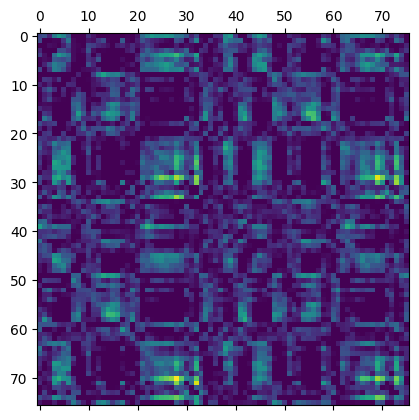

In [388]:
# weight the channels by corresponding gradients
for i in range(activations.size()[1]):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.detach())

tensor([[1.0570e-05, 9.9999e-01, 1.3697e-06]], grad_fn=<ExpBackward0>)
2


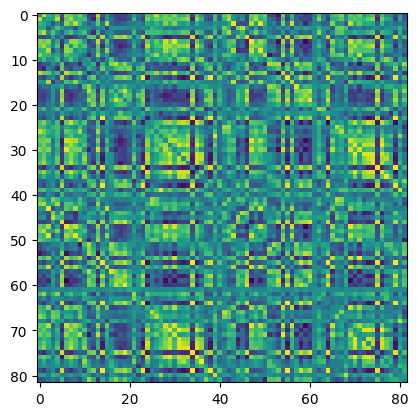

In [389]:
print(torch.exp(pred))
print(label)
plt.imshow(img_tensor.squeeze(0).squeeze(0))

In [296]:
filter_maps = net.fc1.weight.detach().numpy()

## Test sur Jade

In [391]:
forward_hook.remove()
backward_hook.remove()

In [257]:
valid = fc_test.reshape(fc_test.shape[0]*fc_test.shape[1],1,82,82).numpy()
valid_loader = package.torch_classifier.SimpleDataset(valid,labels_test.flatten())

In [259]:
net.eval()

# loop, over whole test set
compteur_batch = 0
net.eval()
test_correct = 0

for i, (batch,target) in enumerate(valid_loader):
    output = net(batch.unsqueeze(0))
    pred = output.max(1, keepdim=True)[1]
    test_correct += pred[0,0].eq(target).sum().item()
    compteur_batch+=1
    
print('Test accuracy {:.2f}%'.format(
    100 * test_correct / (compteur_batch)))

Test accuracy 69.23%


In [351]:
for session in range(fc_test.shape[0]):
    data = fc_test[session,:,:]
    accu = torch.exp(net(data.type(torch.float32)))
    probas = torch.sum(accu,dim = 0) / 464
    res = torch.argmax(probas)
    print("True label : {}, Predicted label : {}, Probas : {}".format(labels_test[session,0],res,probas.detach().numpy()))

True label : 2, Predicted label : 2, Probas : [0.08260743 0.04907328 0.8683193 ]
True label : 2, Predicted label : 0, Probas : [0.3991746  0.2097877  0.39103764]
True label : 2, Predicted label : 2, Probas : [0.20824935 0.37659764 0.415153  ]
True label : 2, Predicted label : 2, Probas : [0.21357825 0.23991624 0.5465055 ]
True label : 2, Predicted label : 2, Probas : [0.02803184 0.01170275 0.96026546]
True label : 2, Predicted label : 2, Probas : [0.03773293 0.12387148 0.8383956 ]
True label : 2, Predicted label : 2, Probas : [0.08220387 0.11487816 0.80291796]
True label : 2, Predicted label : 2, Probas : [0.05534697 0.03153082 0.91312224]
True label : 2, Predicted label : 2, Probas : [0.06470918 0.24968433 0.6856065 ]
True label : 2, Predicted label : 2, Probas : [0.02574341 0.2204306  0.753826  ]
True label : 2, Predicted label : 2, Probas : [0.08076604 0.21384177 0.70539224]
True label : 2, Predicted label : 2, Probas : [0.10680876 0.13237809 0.76081324]
True label : 2, Predicted la

In [392]:
data = fc_test[1,:,:]
probas = torch.exp(net(data.type(torch.float32)))
for i in range(464):
    pred = torch.argmax(probas[i,:])
    if pred < 2 :
        print(i, probas[i,:])

17 tensor([0.0908, 0.6010, 0.3082], grad_fn=<SliceBackward0>)
18 tensor([0.3175, 0.5888, 0.0937], grad_fn=<SliceBackward0>)
19 tensor([0.6369, 0.3419, 0.0213], grad_fn=<SliceBackward0>)
20 tensor([0.9397, 0.0564, 0.0039], grad_fn=<SliceBackward0>)
21 tensor([0.9919, 0.0070, 0.0011], grad_fn=<SliceBackward0>)
22 tensor([9.9920e-01, 5.2046e-04, 2.7982e-04], grad_fn=<SliceBackward0>)
23 tensor([9.9982e-01, 6.8170e-05, 1.0706e-04], grad_fn=<SliceBackward0>)
24 tensor([9.9988e-01, 3.2104e-05, 8.3989e-05], grad_fn=<SliceBackward0>)
25 tensor([9.9981e-01, 6.9146e-05, 1.1805e-04], grad_fn=<SliceBackward0>)
26 tensor([9.9968e-01, 1.7626e-04, 1.4294e-04], grad_fn=<SliceBackward0>)
27 tensor([9.9973e-01, 2.0311e-04, 6.2042e-05], grad_fn=<SliceBackward0>)
28 tensor([9.9984e-01, 1.3627e-04, 2.2127e-05], grad_fn=<SliceBackward0>)
29 tensor([9.9994e-01, 4.9118e-05, 7.9377e-06], grad_fn=<SliceBackward0>)
30 tensor([9.9998e-01, 2.0371e-05, 3.6599e-06], grad_fn=<SliceBackward0>)
31 tensor([1.0000e+00, 2

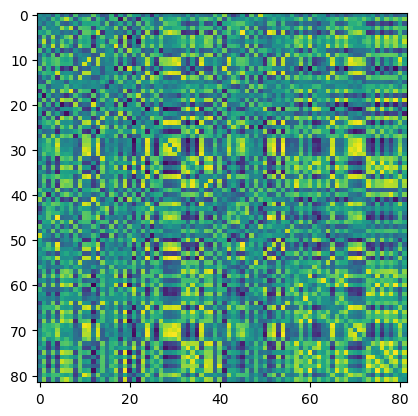

In [402]:
plt.imshow(fc_test[1,247,0,:,:])

In [414]:
session_train = [(i,labels_train[i,0]) for i in range(len(labels_train))]
print(session_train)

[(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 2), (6, 2), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1)]


: 

In [410]:
session_condition = [(i,meta["condition"].iloc[464*i],meta["monkey"].iloc[464*i]) for i in range(len(meta)//464)]

In [411]:
session_condition

[(0, 'awake', 'almira'),
 (1, 'awake', 'almira'),
 (2, 'awake', 'almira'),
 (3, 'awake', 'almira'),
 (4, 'awake', 'jade'),
 (5, 'awake', 'jade'),
 (6, 'awake', 'jade'),
 (7, 'awake', 'jade'),
 (8, 'awake', 'jade'),
 (9, 'awake', 'jade'),
 (10, 'awake', 'jade'),
 (11, 'awake', 'jade'),
 (12, 'awake', 'jade'),
 (13, 'awake', 'jade'),
 (14, 'awake', 'jade'),
 (15, 'awake', 'jade'),
 (16, 'awake', 'jade'),
 (17, 'awake', 'jade'),
 (18, 'awake', 'jade'),
 (19, 'awake', 'jade'),
 (20, 'awake', 'jade'),
 (21, 'awake', 'jade'),
 (22, 'awake', 'khali'),
 (23, 'awake', 'khali'),
 (24, 'awake', 'khali'),
 (25, 'awake', 'khali'),
 (26, 'awake', 'khali'),
 (27, 'awake', 'khali'),
 (28, 'awake', 'khali'),
 (29, 'awake', 'khali'),
 (30, 'awake', 'khali'),
 (31, 'ketamine', 'khali'),
 (32, 'ketamine', 'khali'),
 (33, 'ketamine', 'khali'),
 (34, 'ketamine', 'khali'),
 (35, 'ketamine', 'khali'),
 (36, 'ketamine', 'khali'),
 (37, 'ketamine', 'khali'),
 (38, 'ketamine', 'khali'),
 (39, 'ketamine', 'kimiko

## Cebra with concat

In [9]:
dict_labels = {"light-propofol" : 0, "deep-propofol" : 1, "awake" : 2}

In [57]:
meta_test = meta[meta["monkey"].isin(['jade']) & (meta["condition"].isin(["light-propofol","deep-propofol"]))]["condition"]
labels_test_condition = np.array([meta_test.iloc[i] for i in range(len(meta_test))])
labels_test = np.array([dict_labels[elem] for elem in labels_test_condition]).reshape((len(labels_test_condition)//464,464))

In [26]:
meta_train = meta[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(["light-propofol","deep-propofol"]))]["condition"]
labels_train_condition = np.array([meta_train.iloc[i] for i in range(len(meta_train))])
labels_train = np.array([dict_labels[elem] for elem in labels_train_condition]).reshape((len(labels_train_condition)//464,464))

In [37]:
#We define the architecture of the model we will use

num_output = 3
normalize = True
num_neurons = 3321

model = cebra2.model.Model(
    nn.Conv2d(10, 30, kernel_size=(5,5)),
    nn.ReLU(),
    #self.drop1 = nn.Dropout(0.3)

    nn.Conv2d(30, 30, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(5, 5)),

    nn.Flatten(),

    nn.Linear(1470, 512),
    nn.ReLU(),
    #nn.Dropout(0.5),

    nn.Linear(512, 20),
    nn.Linear(
        20,
        3,
    ),
    num_input=num_neurons,
    num_output=num_output,
    normalize = True
        )

In [52]:
dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana']) & (meta["condition"].isin(['light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
dfc_test = dfc[meta["monkey"].isin(['jade']) & (meta["condition"].isin(['light-propofol', 'deep-propofol']))].reshape((-1, n_wins, 82, 82))
accu = torch.from_numpy(dfc_train.reshape((dfc_train.shape[0]*dfc_train.shape[1],1,82,82)))
fc_train = nn.AvgPool2d(kernel_size=(2, 2),stride = (2,2))(accu).reshape((dfc_train.shape[0],dfc_train.shape[1],1,41,41))
accu = torch.from_numpy(dfc_test.reshape((dfc_test.shape[0]*dfc_train.shape[1],1,82,82)))
fc_test = nn.AvgPool2d(kernel_size=(2, 2),stride = (2,2))(accu).reshape((dfc_test.shape[0],dfc_test.shape[1],1,41,41))

In [53]:
n = 10
fc_train_cat = torch.cat([fc_train[:,i:-n+i,:,:,:] for i in range(n)],dim = 2)
fc_test_cat = torch.cat([fc_test[:,i:-n+i,:,:,:] for i in range(n)],dim = 2)
discrete = labels_train[:,:-10]

In [35]:
fc_dataset = cebra2.dataset.SimpleMultiSessionDataset(fc_train_cat,discrete = discrete)
fc_loader = cebra2.dataset.MultiSessionLoader(fc_dataset, num_steps = 1000, batch_size = 500,  time_delta = 5) #, matrix_delta = 0.5)

In [38]:
cebra_fc = single_session_solver(data_loader = fc_loader, model_architecture = 'offset1-model', 
                 distance = 'cosine', num_hidden_units = 128, output_dimension = 128,
                verbose = True, temperature = 1, beta = 1,learning_rate = 3e-4, model = model)

cebra_fc.fit(fc_loader)

Epoch 0
Train loss 6.2144, Train accuracy 0.00%
Epoch 100
Train loss 5.8930, Train accuracy 0.00%
Epoch 200
Train loss 5.8174, Train accuracy 0.00%
Epoch 300
Train loss 5.7245, Train accuracy 0.00%
Epoch 400
Train loss 5.6713, Train accuracy 0.00%
Epoch 500
Train loss 5.6242, Train accuracy 0.00%
Epoch 600
Train loss 5.6352, Train accuracy 0.00%
Epoch 700
Train loss 5.6304, Train accuracy 0.00%
Epoch 800
Train loss 5.6140, Train accuracy 0.00%
Epoch 900
Train loss 5.6257, Train accuracy 0.00%


KeyboardInterrupt: 